**Upload Google Form CSV**

In [ ]:
from google.colab import files
import io, pandas as pd

uploaded = files.upload()   # this will open a file upload dialog

Saving college_event_feedback.csv to college_event_feedback (1).csv


In [ ]:
fn = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fn]), parse_dates=['Timestamp'], encoding='utf-8', low_memory=False)

In [ ]:
df.head()

,Timestamp,Event,Department,Year,Rating,Comments
0,2024-03-12 13:00:00,Sports Meet,MBA,3rd Year,1,The event started late and ended abruptly.
1,2024-04-24 15:00:00,Tech Talk,CSE,4th Year,1,"The timing was poor, it clashed with classes."
2,2024-06-29 16:00:00,Tech Talk,Civil,1st Year,3,Decent experience overall.
3,2024-02-22 09:00:00,Hackathon,MBA,1st Year,4,"Loved the energy, great speakers and topics."
4,2024-03-31 10:00:00,Workshop on AI,CSE,2nd Year,5,"Fantastic, would definitely attend again."


In [ ]:
df = df.rename(columns=lambda c: c.strip().lower().replace(' ', '_'))
# example to clean rating column
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.drop_duplicates(subset=['timestamp','comments'])


Exploratory data analysis (EDA)- ratings

In [ ]:
df['rating'].describe()  # mean, std, min, max
df['rating'].value_counts().sort_index()


,count
rating,
1,45
2,54
3,37
4,42
5,42


**Visualizations**

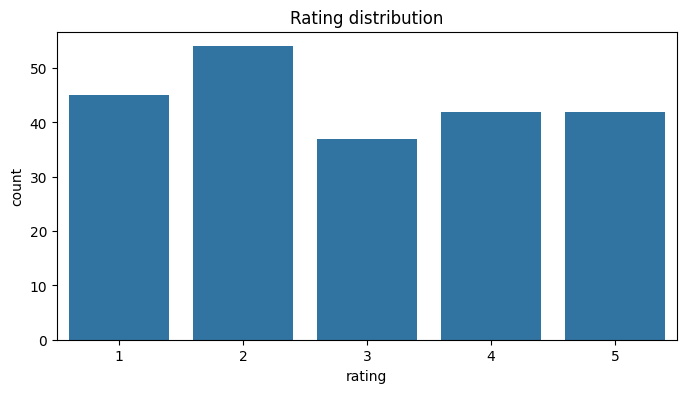

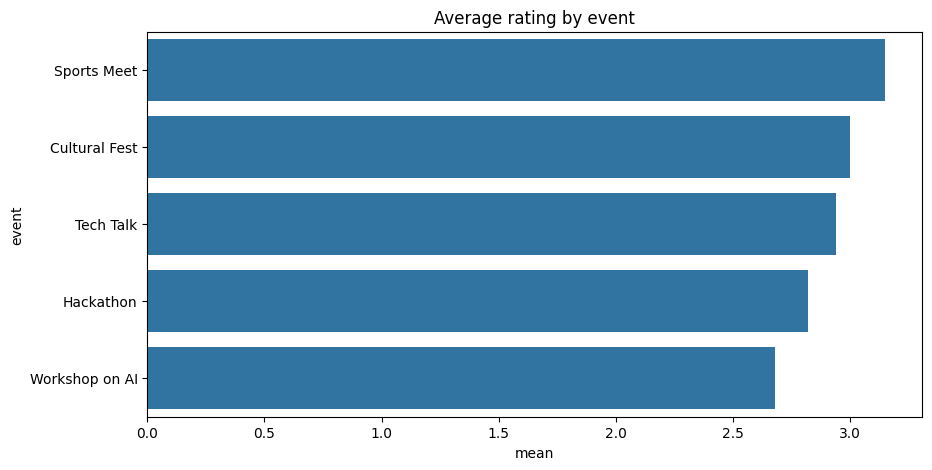

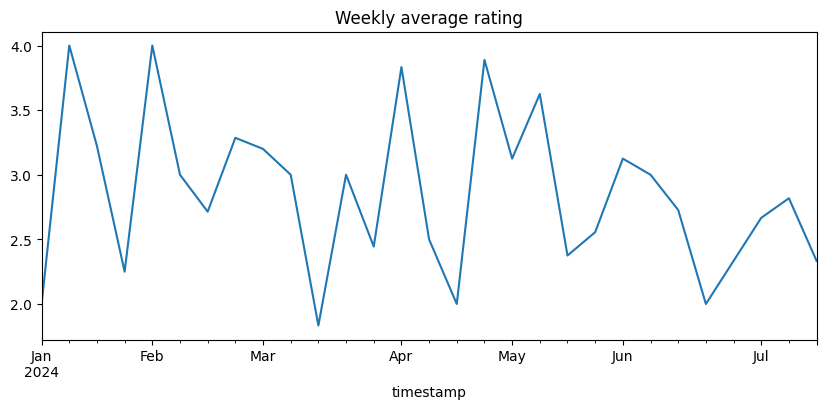

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(x='rating', data=df)
plt.title('Rating distribution')
plt.show()

# mean rating per event
plt.figure(figsize=(10,5))
event_stats = df.groupby('event')['rating'].agg(['mean','count']).reset_index().sort_values('mean',ascending=False)
sns.barplot(x='mean', y='event', data=event_stats)
plt.title('Average rating by event')
plt.show()

# ratings over time (if timestamp present)
time_series = df.set_index('timestamp').resample('W')['rating'].mean().dropna()
time_series.plot(title='Weekly average rating', figsize=(10,4))
plt.show()


**Sentiment analysis**

In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def tb_polarity(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0.0

def vader_compound(text):
    try:
        return analyzer.polarity_scores(str(text))['compound']
    except:
        return 0.0

df['tb_polarity'] = df['comments'].fillna('').apply(tb_polarity)
df['vader_compound'] = df['comments'].fillna('').apply(vader_compound)

# simple ensemble (average)
df['sentiment_score'] = (df['tb_polarity'] + df['vader_compound'])/2


In [ ]:
def label_from_score(s):
    if s >= 0.05: return 'positive'
    if s <= -0.05: return 'negative'
    return 'neutral'

df['sentiment_label'] = df['sentiment_score'].apply(label_from_score)


Validate sentiment and sample check

In [ ]:
df.sample(30)[['comments','sentiment_score','sentiment_label']]


,comments,sentiment_score,sentiment_label
86,"Really enjoyed the session, very informative.",0.453150,positive
217,"Really enjoyed the session, very informative.",0.453150,positive
95,"Fantastic, would definitely attend again.",0.471500,positive
130,The event was well organized and engaging!,0.542400,positive
197,"The timing was poor, it clashed with classes.",-0.438350,negative
205,Venue was too crowded and uncomfortable.,-0.440900,negative
25,"Loved the energy, great speakers and topics.",0.813950,positive
108,"It was okay, nothing special.",0.168286,positive
158,"Fantastic, would definitely attend again.",0.471500,positive
12,Venue was too crowded and uncomfortable.,-0.440900,negative


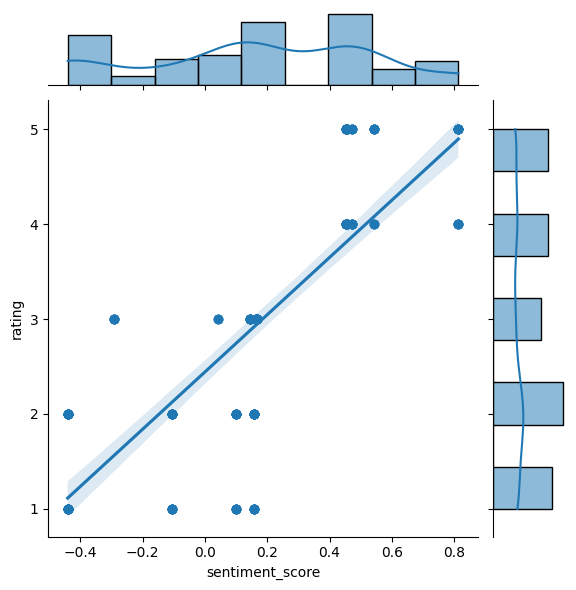

In [ ]:
df[['rating','sentiment_score']].corr()
sns.jointplot(x='sentiment_score', y='rating', data=df, kind='reg')
plt.show()


In [ ]:
event_summary = df.groupby('event').agg(
    avg_rating=('rating','mean'),
    avg_sentiment=('sentiment_score','mean'),
    responses=('rating','count')
).reset_index().sort_values('avg_rating')


In [ ]:
# Convert 1-5 -> promoters (4-5), passive (3), detractors (1-2)
event_summary['promoters_pct'] = df[df['rating']>=4].groupby('event')['rating'].count()/df.groupby('event')['rating'].count()

Aspect/topic-level sentiment

In [ ]:
aspects = {
 'speaker': ['speaker','presenter','talk','lecture','content'],
 'timing': ['time','schedule','late','timing','duration'],
 'food': ['food','snacks','refreshment','catering'],
 'venue': ['hall','room','venue','seats','ac']
}

def aspect_sentiments(row):
    txt = str(row['comments']).lower()
    results = {}
    for a, kws in aspects.items():
        if any(k in txt for k in kws):
            results[a] = row['sentiment_score']
    return results

# apply and then aggregate per aspect
df['aspect_scores'] = df.apply(aspect_sentiments, axis=1)
# explode and aggregate (left as exercise) — you'll get avg sentiment per aspect


Visua;ization (seaborn+wordcloud)

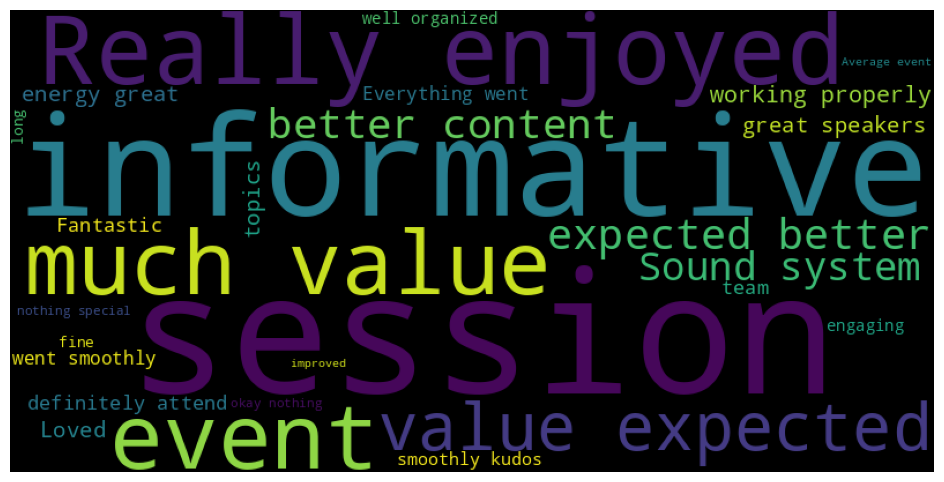

In [ ]:
from wordcloud import WordCloud
pos_text = ' '.join(df[df['sentiment_label']=='positive']['comments'].dropna().astype(str))
wc = WordCloud(width=800, height=400).generate(pos_text)
plt.figure(figsize=(12,6)); plt.imshow(wc); plt.axis('off'); plt.show()


Download the Feedback with sentiment

In [ ]:
df.to_csv('feedback_with_sentiment.csv', index=False)
from google.colab import files
files.download('feedback_with_sentiment.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>